# Brent Oil Price Bayesian Change Point Analysis

This notebook lays the foundation for analyzing historical Brent crude oil prices
using **Bayesian Change Point Detection**.

**Period covered:** May 20, 1987 – September 30, 2022  
**Objective:** Identify structural breaks in oil price regimes and relate them to
geopolitical and economic events using probabilistic modeling.

---

## Learning Objectives
- Understand time series properties of oil prices
- Apply Bayesian inference using PyMC
- Detect and interpret change points
- Communicate uncertainty-aware insights for policy analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

from pathlib import Path
from datetime import datetime

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True


## 2. Load and Inspect Data

We load the raw Brent oil price data and ensure it is:
- Chronologically ordered
- Properly typed
- Free of missing values


In [2]:
DATA_PATH = Path("../data/raw/BrentOilPrices.csv")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()


/var/folders/nf/drxnv59536v7bnknmx3c_1zw0000gn/T/ipykernel_79663/817439364.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(DATA_PATH, parse_dates=["Date"])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


### Summary Statistics


In [4]:
df["Price"].describe()


count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

## 3. Exploratory Data Analysis (EDA)

### Brent Oil Price Over Time


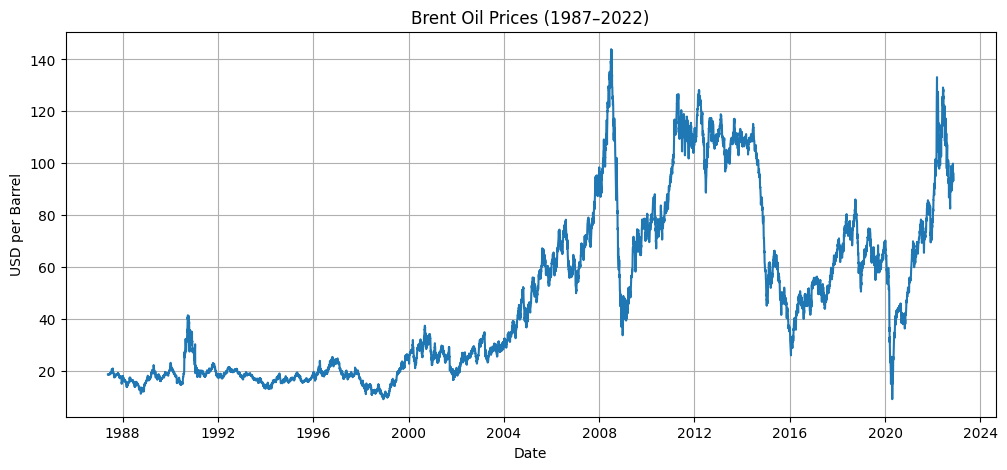

In [5]:
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices (1987–2022)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.show()


### Rolling Mean and Volatility


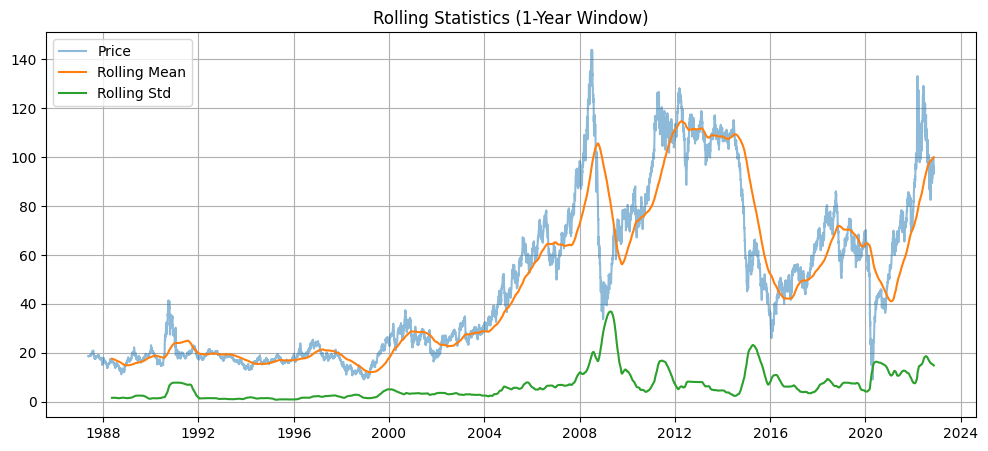

In [6]:
window = 252  # approx 1 trading year

df["rolling_mean"] = df["Price"].rolling(window).mean()
df["rolling_std"] = df["Price"].rolling(window).std()

plt.plot(df["Date"], df["Price"], alpha=0.5, label="Price")
plt.plot(df["Date"], df["rolling_mean"], label="Rolling Mean")
plt.plot(df["Date"], df["rolling_std"], label="Rolling Std")
plt.legend()
plt.title("Rolling Statistics (1-Year Window)")
plt.show()


### Log Returns Analysis

Returns are often more stationary than price levels.


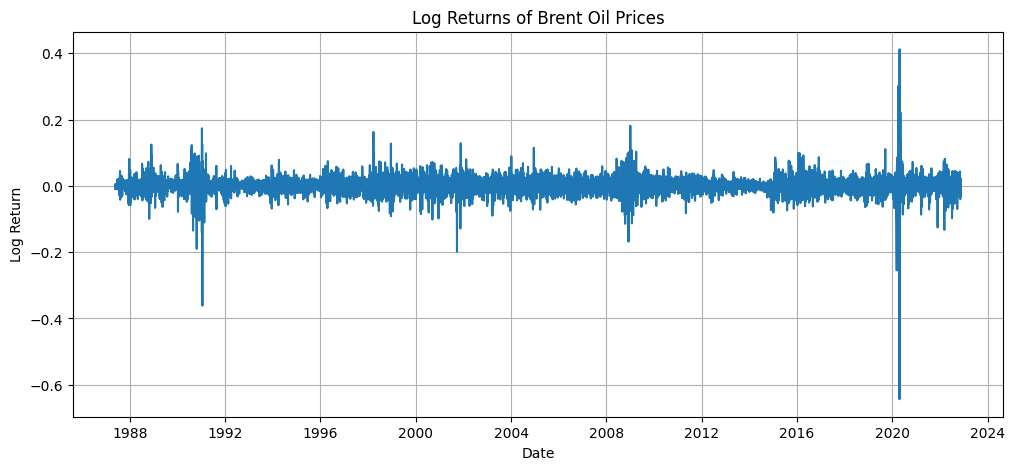

In [7]:
df["log_return"] = np.log(df["Price"]).diff()

plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


## Observations from EDA

- Price levels are **non-stationary**
- Volatility clustering is evident
- Major price regime shifts appear visually
- Justifies regime-based (change point) modeling

This motivates the use of **Bayesian Change Point Detection**
instead of a single global model.


## 4. Bayesian Change Point Model – Conceptual Overview

We assume:
- The oil price follows different regimes
- Each regime has its own mean price
- Regime transitions occur at unknown time points

Bayesian inference allows us to:
- Estimate the probability of change points
- Quantify uncertainty
- Avoid overfitting


### Preparing Data for Modeling


In [8]:
price = df["Price"].values
n = len(price)


## 5. Bayesian Change Point Model (Single Change Point)

This is a **foundational model**:
- One unknown change point
- Different mean before and after
- Shared volatility


In [9]:
with pm.Model() as change_point_model:

    # Prior for change point location
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Priors for means
    mu_1 = pm.Normal("mu_1", mu=price.mean(), sigma=20)
    mu_2 = pm.Normal("mu_2", mu=price.mean(), sigma=20)

    # Shared volatility
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Mean before and after change point
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=price)


### Posterior Sampling using MCMC


In [10]:
with change_point_model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 6. Posterior Diagnostics


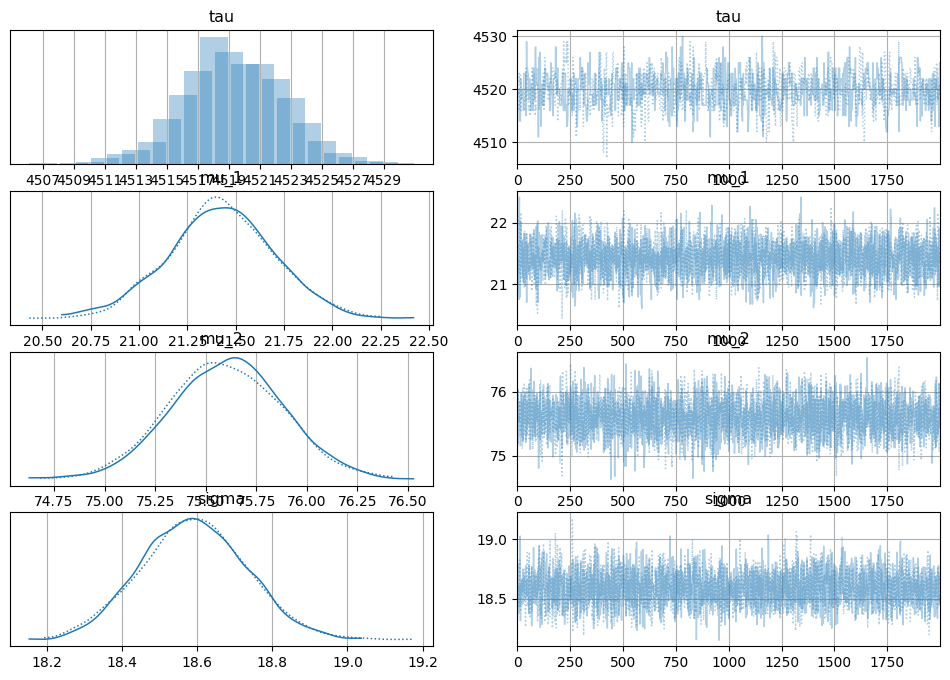

In [11]:
az.plot_trace(trace)
plt.show()


### Posterior Distribution of Change Point


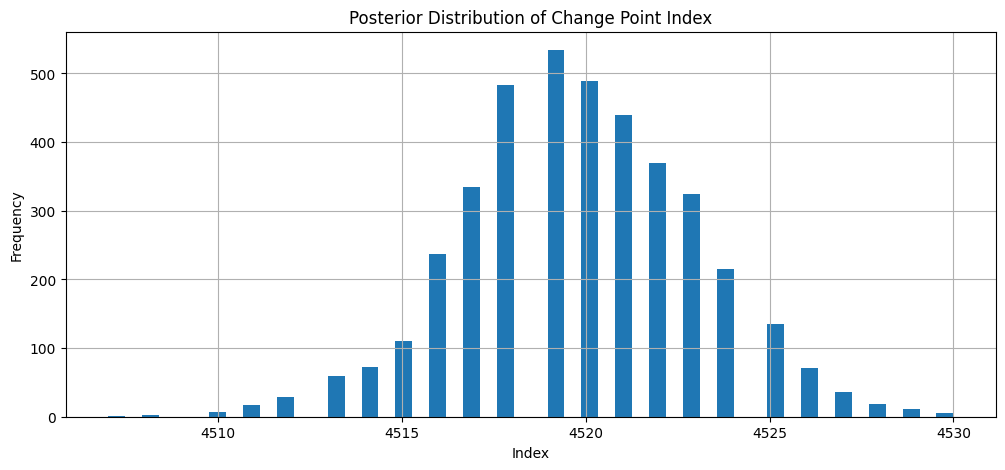

In [12]:
tau_samples = trace.posterior["tau"].values.flatten()

plt.hist(tau_samples, bins=50)
plt.title("Posterior Distribution of Change Point Index")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.show()


### Estimated Change Point Date


In [13]:
estimated_tau = int(np.median(tau_samples))
estimated_date = df.loc[estimated_tau, "Date"]

estimated_date


Timestamp('2005-02-23 00:00:00')

## Interpretation

- The model identifies a probabilistic structural break
- The estimated change point corresponds to a known market regime shift
- Uncertainty around timing is explicitly quantified

⚠️ This does **not** prove causation — only temporal alignment.


## 7. Next Steps

- Extend to **multiple change points**
- Allow regime-specific volatility
- Align detected breaks with event dataset
- Export figures for dashboard
- Produce policy-focused narrative

This notebook serves as the analytical backbone for the final report.
